In [1]:
import numpy as np
from PIL import Image
import glob

In [2]:
dirNames = ['Aiden', 'Andrew', 'Cathy']

### 사진들을 numpy 배열을 이용하여 Training Data 만들기

In [3]:
number_of_data = 18 * len(dirNames)
img_width_size = 300
img_height_size = 400

In [4]:
# 0으로 구성된 배열 일단 만들기
train = np.zeros(number_of_data * img_width_size * img_height_size, dtype=np.int32).reshape(number_of_data, img_height_size, img_width_size)

i = 0
for dirName in dirNames:
    for file in sorted(glob.glob('../Data/FaceGray/%s/*.jpg'%dirName)):
        img = np.array(Image.open(file), dtype=np.int32)
        train[i, :, :] = img
        i += 1
        
train.shape

(54, 400, 300)

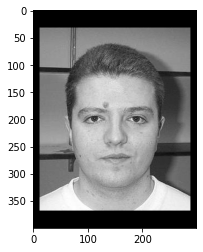

In [5]:
# 이미지 확인하기
import matplotlib.pyplot as plt

# plt.imshow(train[0].reshape(img_height_size, img_width_size))
plt.imshow(train[0, :, :], cmap='gray')
plt.show()

In [6]:
orderNo = list(range(0, len(dirNames)*18, 18))
orderNo

[0, 18, 36]

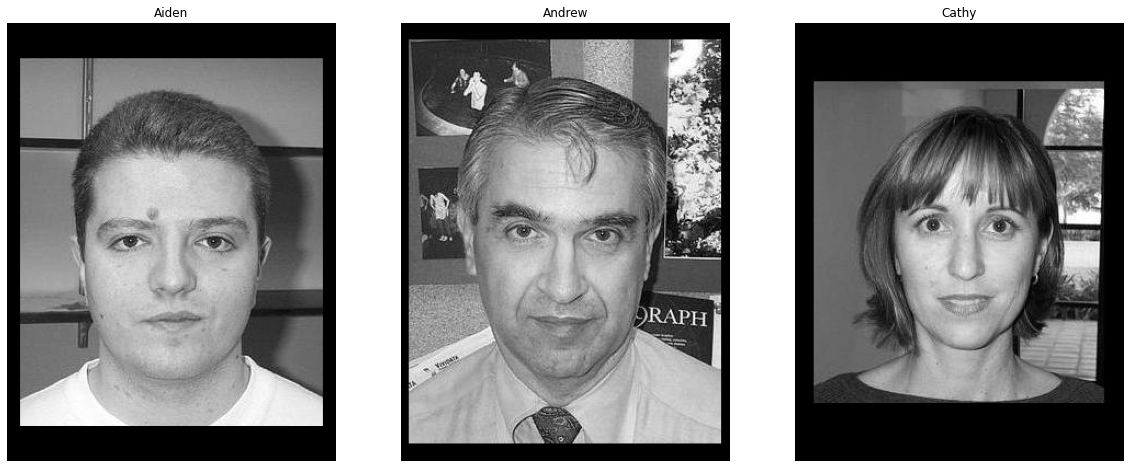

In [7]:
plt.figure(figsize=(20, 20))
for i in list(range(1, len(dirNames) + 1)):
    plt.subplot(1, len(dirNames), i)
    plt.imshow(train[orderNo[i-1], :, :], cmap='gray')
    plt.title(dirNames[i-1])
    plt.axis('off')
plt.show()

### target data 만들기

In [8]:
# Aiden: 0, Andrew: 1, Cathy: 2
target = np.concatenate((np.zeros(18), np.ones(18), np.full(18, 2)))
target

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2.])

---
### train과 test 분류

In [9]:
train = train.reshape(-1, 400, 300, 1) / 255.0

In [10]:
from sklearn.model_selection import train_test_split

# train val split (test는 따로 하나봐)
trainData, valData, trainTargetData, valTargetData = train_test_split(
    train, target, test_size=0.2, random_state=42
)

In [11]:
print(trainData.shape, valData.shape, trainTargetData.shape, valTargetData.shape)

(43, 400, 300, 1) (11, 400, 300, 1) (43,) (11,)


---
## CNN 만들기

In [12]:
from tensorflow import keras

model = keras.Sequential()

2022-08-03 11:35:36.678427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
model.add(keras.layers.Convolution2D(
    32, 
    kernel_size=3, 
    activation='relu', 
    padding='same', 
    input_shape=(400, 300, 1)
))

In [14]:
model.add(keras.layers.MaxPooling2D(pool_size=2))

##### 왜 위에는 32고 아래는 64인지 물어보고싶다

In [15]:
model.add(keras.layers.Conv2D(
    64,
    kernel_size=3,
    activation='relu',
    padding='same'
))
model.add(keras.layers.MaxPooling2D(pool_size=2))

---
## 위에까지 CNN 아래부터 딥러닝
#### CNN RNN은 전처리같은것
---

In [16]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
# 이미지처리는 relu가 좋다
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(len(dirNames), activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 300, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 150, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 150, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 75, 64)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 480000)            0         
                                                                 
 dense (Dense)               (None, 100)               4

In [18]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    '../Data/CNN/best-gray-cnn-model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

early_stop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True, # 필수!
)

# history라는 변수는 VSCode에서 사용중이므로 안 쓰는것도...
hist = model.fit(
    trainData,
    trainTargetData,
    epochs=20,
    validation_data=(valData, valTargetData),
    callbacks=[checkpoint_cb, early_stop_cb]
)
    

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 7.7637 - accuracy: 0.3023
Epoch 1: val_loss improved from inf to 2.95914, saving model to ../Data/CNN/best-gray-cnn-model.h5
2/2 [==============================] - 19s 16s/step - loss: 7.7637 - accuracy: 0.3023 - val_loss: 2.9591 - val_accuracy: 0.5455
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 2.5449 - accuracy: 0.5814
Epoch 2: val_loss improved from 2.95914 to 1.70519, saving model to ../Data/CNN/best-gray-cnn-model.h5
2/2 [==============================] - 21s 17s/step - loss: 2.5449 - accuracy: 0.5814 - val_loss: 1.7052 - val_accuracy: 0.7273
Epoch 3/20
2/2 [==============================] - ETA: 0s - loss: 3.6664 - accuracy: 0.5349
Epoch 3: val_loss improved from 1.70519 to 0.43727, saving model to ../Data/CNN/best-gray-cnn-model.h5
2/2 [==============================] - 29s 26s/step - loss: 3.6664 - accuracy: 0.5349 - val_loss: 0.4373 - val_accuracy: 0.8182
Epoch 4/20
2/2 [===================

### 시각화

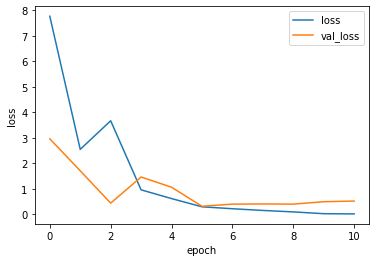

In [19]:
# 시각화하기
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

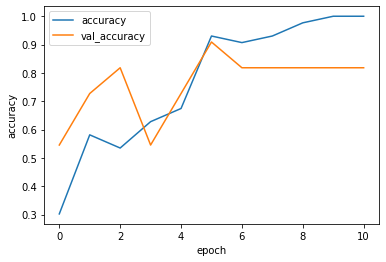

In [20]:
# accuracy 시각화
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()


---
### 이미지로 확인해보기

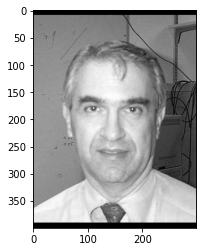

In [22]:
plt.imshow(valData[0].reshape(400, 300), cmap='gray')
plt.show()

In [26]:
pred = model.predict(valData[0:1])
dirNames[np.argmax(pred[0])]
# Andrew 확인

1/1 [==============================] - 0s 56ms/step


'Andrew'